## Installazione Pacchetti

Installazione di tutte le librerie necessarie per il progetto.

In [ ]:
# Installazione pacchetti necessari
import sys
import subprocess

packages = [
    'transformers>=4.30.0',
    'datasets',
    'torch',
    'accelerate',
    'sentencepiece',
    'huggingface-hub',
    'peft',  # LoRA library
    'tqdm',
    'scikit-learn'
]

print("Installazione pacchetti (incluso PEFT per LoRA)...")
for package in packages:
    try:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])
    except:
        print(f"Errore nell'installazione di {package}")

print("Pacchetti installati con successo!")

📦 Installazione pacchetti (incluso PEFT per LoRA)...
⚠ Errore nell'installazione di datasets
⚠ Errore nell'installazione di huggingface-hub
⚠ Errore nell'installazione di peft
✅ Pacchetti installati con successo!


## Autenticazione HuggingFace

Configurazione del token HuggingFace.
- **VS Code**: Imposta la variabile d'ambiente `HF_TOKEN`
- **Google Colab**: Usa Colab Secrets

In [2]:
from huggingface_hub import login
import os

# Get HuggingFace token from environment variable
# Per impostare il token: set HF_TOKEN=your_token_here (Windows PowerShell)
# Oppure su Google Colab: userdata.get('HF_TOKEN')
try:
    # Prova prima con variabile d'ambiente (per VS Code)
    HF_TOKEN = os.getenv('HF_TOKEN')

    if HF_TOKEN is None:
        # Fallback per Google Colab
        try:
            from google.colab import userdata
            HF_TOKEN = userdata.get('HF_TOKEN')
        except:
            print("HF_TOKEN non trovato. Puoi impostarlo con:")
            print("  - Windows: $env:HF_TOKEN='your_token'")
            print("  - Linux/Mac: export HF_TOKEN='your_token'")
            print("  - Google Colab: Aggiungi HF_TOKEN ai Secrets")
            HF_TOKEN = None

    if HF_TOKEN:
        # Login to HuggingFace
        login(token=HF_TOKEN)
        print("Successfully authenticated with HuggingFace!")
    else:
        print("Continuando senza autenticazione HuggingFace.")
        print("  Alcuni modelli potrebbero non essere accessibili.")

except Exception as e:
    print(f"Errore durante l'autenticazione: {e}")
    print("  Continuando senza autenticazione HuggingFace.")

Successfully authenticated with HuggingFace!


In [3]:
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Transformers & PEFT
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    BitsAndBytesConfig,
    pipeline,
    AutoModel,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    get_linear_schedule_with_warmup
)
from peft import LoraConfig, get_peft_model, PeftModel, prepare_model_for_kbit_training

# PyTorch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import AdamW

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Set seed per riproducibilità
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA A100-SXM4-80GB
GPU Memory: 85.17 GB


## Configurazione Dataset

Configurazione degli URL per il caricamento dei dati da GitHub.

In [4]:
# Configuration
TRACK = "track_a"
SUBTASK = "3"  # Subtask 3 per Quadruplet Extraction (DimASQP)
LANGUAGE = "eng"  # Lingua: eng, jpn, rus, tat, ukr, zho
DOMAIN = "restaurant"  # Dominio: restaurant, laptop, hotel

# Build GitHub URLs
BASE_URL = "https://raw.githubusercontent.com/DimABSA/DimABSA2026/main/task-dataset"
TRAIN_URL = f"{BASE_URL}/{TRACK}/subtask_{SUBTASK}/{LANGUAGE}/{LANGUAGE}_{DOMAIN}_train_alltasks.jsonl"

# Display configuration
print("="*60)
print("CONFIGURAZIONE DATASET")
print("="*60)
print(f"Track:     {TRACK}")
print(f"Subtask:   {SUBTASK} (Quadruplet Extraction - DimASQP)")
print(f"Language:  {LANGUAGE}")
print(f"Domain:    {DOMAIN}")
print(f"\nTrain URL: {TRAIN_URL}")
print("="*60)

CONFIGURAZIONE DATASET
Track:     track_a
Subtask:   3 (Quadruplet Extraction - DimASQP)
Language:  eng
Domain:    restaurant

Train URL: https://raw.githubusercontent.com/DimABSA/DimABSA2026/main/task-dataset/track_a/subtask_3/eng/eng_restaurant_train_alltasks.jsonl


# DimABSA Track A - Subtask 3: Dimensional Aspect Sentiment Quad Prediction (DimASQP)

## Obiettivo
Dato un testo, estrarre tutti i **quadruplet (Aspect, Category, Opinion, VA)** dove:
- **Aspect**: termine che indica l'aspetto target (può essere NULL)
- **Category**: categoria dell'aspetto nel formato ENTITY#ATTRIBUTE (NON è mai NULL, sempre UPPERCASE)
- **Opinion**: termine che esprime il sentiment (può essere NULL)
- **VA**: punteggio Valence-Arousal (V#A) con valori da 1.00 a 9.00

## Pipeline
1. **Estrazione Aspect/Category/Opinion**: Uso di LLM (LLAMA) con prompt engineering
2. **Predizione VA**: Modello encoder (BERT multilingua) per predire i valori continui

---

## 1. Setup e Import Librerie

In [5]:
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Transformers
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    BitsAndBytesConfig,
    pipeline,
    AutoModel
)

# PyTorch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import AdamW

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Set seed per riproducibilità
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA A100-SXM4-80GB


## 2. Analisi del Dataset

In [6]:
def load_jsonl_from_url(url: str) -> List[Dict]:
    """
    Carica dati JSONL da un URL GitHub.

    Args:
        url: URL del file JSONL

    Returns:
        Lista di dizionari
    """
    import urllib.request

    try:
        print(f"⏳ Caricamento da {url.split('/')[-1]}...")
        with urllib.request.urlopen(url) as response:
            data = response.read().decode('utf-8')
            items = [json.loads(line) for line in data.strip().split('\n') if line.strip()]
        print(f"✓ Caricati {len(items)} esempi")
        return items
    except Exception as e:
        print(f"❌ Errore nel caricamento da {url}: {e}")
        raise

# Caricamento dati
train_data = load_jsonl_from_url(TRAIN_URL)
print(f"\n{'='*60}")
print(f"DATASET CARICATO")
print(f"{'='*60}")
print(f"Numero di esempi nel training set: {len(train_data)}")
print(f"\nEsempio di dato:")
print(json.dumps(train_data[0], indent=2))


⏳ Caricamento da eng_restaurant_train_alltasks.jsonl...
✓ Caricati 2284 esempi

DATASET CARICATO
Numero di esempi nel training set: 2284

Esempio di dato:
{
  "ID": "rest16_quad_dev_1",
  "Text": "ca n ' t wait wait for my next visit .",
  "Quadruplet": [
    {
      "Aspect": "NULL",
      "Opinion": "NULL",
      "Category": "RESTAURANT#GENERAL",
      "VA": "6.75#6.38"
    }
  ]
}


## 🔄 Gestione Split Dataset: LLM Extraction vs VA Training

**Obiettivo**: Separare chiaramente:
- **LLM Extraction Split**: Per testare LLAMA su train/val/test mantenendo consistenza
- **VA Training Dataset**: Usa sempre gli stessi ID record originali per training BERT

Questo permette di:
1. Testare l'estrazione di LLAMA su subset diversi (train/val/test)
2. Mantenere coerenza negli ID dei record quando si traina il modello VA
3. Garantire riproducibilità e confrontabilità dei risultati

In [7]:
def create_dataset_splits(data: List[Dict],
                         train_ratio: float = 0.7,
                         val_ratio: float = 0.15,
                         test_ratio: float = 0.15,
                         seed: int = 42):
    """
    Crea split consistenti per train/val/test mantenendo gli ID originali.

    Args:
        data: Dataset completo
        train_ratio: Percentuale per training set
        val_ratio: Percentuale per validation set
        test_ratio: Percentuale per test set
        seed: Random seed per riproducibilità

    Returns:
        Tuple (train_data, val_data, test_data) con ID originali preservati
    """
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Le proporzioni devono sommare a 1.0"

    # Shuffle con seed fisso per riproducibilità
    np.random.seed(seed)
    indices = np.random.permutation(len(data))

    # Calcola dimensioni degli split
    n_train = int(len(data) * train_ratio)
    n_val = int(len(data) * val_ratio)

    # Split degli indici
    train_indices = indices[:n_train]
    val_indices = indices[n_train:n_train + n_val]
    test_indices = indices[n_train + n_val:]

    # Crea i subset mantenendo gli ID originali
    train_split = [data[i] for i in train_indices]
    val_split = [data[i] for i in val_indices]
    test_split = [data[i] for i in test_indices]

    # Salva gli indici per riferimento futuro
    split_info = {
        'train_indices': train_indices.tolist(),
        'val_indices': val_indices.tolist(),
        'test_indices': test_indices.tolist(),
        'train_ids': [item['ID'] for item in train_split],
        'val_ids': [item['ID'] for item in val_split],
        'test_ids': [item['ID'] for item in test_split]
    }

    return train_split, val_split, test_split, split_info


# Crea gli split
print("\n" + "="*80)
print("📊 CREAZIONE SPLIT DATASET (Train/Val/Test)")
print("="*80)

train_split_data, val_split_data, test_split_data, split_info = create_dataset_splits(
    data=train_data,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    seed=SEED
)

print(f"\n✅ Split creati con successo:")
print(f"  - Training set:   {len(train_split_data)} esempi ({len(train_split_data)/len(train_data)*100:.1f}%)")
print(f"  - Validation set: {len(val_split_data)} esempi ({len(val_split_data)/len(train_data)*100:.1f}%)")
print(f"  - Test set:       {len(test_split_data)} esempi ({len(test_split_data)/len(train_data)*100:.1f}%)")
print(f"\n📋 ID preservati:")
print(f"  - Train IDs: {train_split_data[0]['ID']}, {train_split_data[1]['ID']}, ...")
print(f"  - Val IDs:   {val_split_data[0]['ID']}, {val_split_data[1]['ID']}, ...")
print(f"  - Test IDs:  {test_split_data[0]['ID']}, {test_split_data[1]['ID']}, ...")
print("="*80)


📊 CREAZIONE SPLIT DATASET (Train/Val/Test)

✅ Split creati con successo:
  - Training set:   1598 esempi (70.0%)
  - Validation set: 342 esempi (15.0%)
  - Test set:       344 esempi (15.1%)

📋 ID preservati:
  - Train IDs: rest16_quad_test_213, rest16_quad_train_1432, ...
  - Val IDs:   rest16_quad_dev_80, rest16_quad_train_419, ...
  - Test IDs:  rest16_quad_train_413, rest16_quad_test_300, ...


In [8]:
def create_prompt_for_training(text: str) -> str:
    """Crea prompt few-shot per estrazione AOC (versione training)."""
    prompt = f"""### TASK
You are an aspect-category-opinion extraction system for restaurant reviews. Extract triplets and return ONLY a valid JSON array.

### RULES:
1. ASPECT = target entity/attribute. Use "NULL" if implicit.
2. CATEGORY = Entity#Attribute in UPPERCASE (e.g., "FOOD#QUALITY"). NEVER NULL.
3. OPINION = sentiment word/phrase from text. Use "NULL" if implicit.
4. Return ONLY the JSON array, nothing else.

VALID CATEGORIES:
- Entities: RESTAURANT, FOOD, DRINKS, AMBIENCE, SERVICE, LOCATION
- Attributes: GENERAL, PRICES, QUALITY, STYLE_OPTIONS, MISCELLANEOUS

### EXAMPLES:

Text: "the spicy tuna roll was unusually good and the rock shrimp tempura was awesome."
[{{"aspect": "spicy tuna roll", "category": "FOOD#QUALITY", "opinion": "unusually good"}}, {{"aspect": "rock shrimp tempura", "category": "FOOD#QUALITY", "opinion": "awesome"}}]

Text: "we love the pink pony."
[{{"aspect": "pink pony", "category": "RESTAURANT#GENERAL", "opinion": "love"}}]

Text: "the food here is rather good, but only if you like to wait for it."
[{{"aspect": "food", "category": "FOOD#QUALITY", "opinion": "rather good"}}, {{"aspect": "NULL", "category": "SERVICE#GENERAL", "opinion": "NULL"}}]

### INPUT
Text: "{text}"

### OUTPUT
"""
    return prompt

# Test prompt
test_text = "The food was amazing but the service was slow."
print("📝 Esempio di prompt per training:")
print("="*80)
print(create_prompt_for_training(test_text))
print("="*80)

📝 Esempio di prompt per training:
### TASK
You are an aspect-category-opinion extraction system for restaurant reviews. Extract triplets and return ONLY a valid JSON array.

### RULES:
1. ASPECT = target entity/attribute. Use "NULL" if implicit.
2. CATEGORY = Entity#Attribute in UPPERCASE (e.g., "FOOD#QUALITY"). NEVER NULL.
3. OPINION = sentiment word/phrase from text. Use "NULL" if implicit.
4. Return ONLY the JSON array, nothing else.

VALID CATEGORIES:
- Entities: RESTAURANT, FOOD, DRINKS, AMBIENCE, SERVICE, LOCATION
- Attributes: GENERAL, PRICES, QUALITY, STYLE_OPTIONS, MISCELLANEOUS

### EXAMPLES:

Text: "the spicy tuna roll was unusually good and the rock shrimp tempura was awesome."
[{"aspect": "spicy tuna roll", "category": "FOOD#QUALITY", "opinion": "unusually good"}, {"aspect": "rock shrimp tempura", "category": "FOOD#QUALITY", "opinion": "awesome"}]

Text: "we love the pink pony."
[{"aspect": "pink pony", "category": "RESTAURANT#GENERAL", "opinion": "love"}]

Text: "the food

In [9]:
def _parse_json_response_lora(response: str) -> List[Dict[str, str]]:
    """
    Rimuove token non-JSON dall'output e parsa il risultato.
    """
    import re

    try:
        # Step 1: Rimuovi markdown
        response = response.replace('```json', '').replace('```', '').strip()

        # Step 2: Trova tutti gli array JSON
        candidates = re.findall(r'\[[\s\S]*?\]', response)

        for json_str in candidates:
            try:
                result = json.loads(json_str)

                if isinstance(result, list) and len(result) > 0:
                    normalized = []
                    seen = set()

                    for item in result:
                        if not isinstance(item, dict):
                            continue

                        aspect = str(item.get('aspect', item.get('Aspect', 'NULL'))).strip()
                        category = str(item.get('category', item.get('Category', 'RESTAURANT#GENERAL'))).strip().upper()
                        opinion = str(item.get('opinion', item.get('Opinion', 'NULL'))).strip()

                        if not aspect:
                            aspect = 'NULL'
                        if not opinion:
                            opinion = 'NULL'
                        if not category or category == 'NULL':
                            category = 'RESTAURANT#GENERAL'

                        # Rimuovi duplicati
                        triplet_key = (aspect.lower(), category, opinion.lower())
                        if triplet_key not in seen:
                            seen.add(triplet_key)
                            normalized.append({
                                'Aspect': aspect,
                                'Category': category,
                                'Opinion': opinion
                            })

                    if normalized:
                        return normalized

            except json.JSONDecodeError:
                continue

        # Fallback
        return [{'Aspect': 'NULL', 'Category': 'RESTAURANT#GENERAL', 'Opinion': 'NULL'}]

    except Exception:
        return [{'Aspect': 'NULL', 'Category': 'RESTAURANT#GENERAL', 'Opinion': 'NULL'}]

print("✅ Funzioni di inference per LoRA definite")

✅ Funzioni di inference per LoRA definite


## Caricamento Modello LoRA Salvato

Per caricare un checkpoint LoRA salvato in futuro:

In [10]:
def load_lora_checkpoint(checkpoint_path: str, model_name: str = "meta-llama/Llama-3.2-3B-Instruct"):
    """
    Carica un modello LoRA da checkpoint.

    Args:
        checkpoint_path: Path alla directory del checkpoint LoRA (es. "./lora_checkpoints/final" o "./lora_checkpoints/checkpoint-XXXX")
        model_name: Nome del modello base da caricare

    Returns:
        Tuple (model, tokenizer) - Modello LoRA caricato e tokenizer
    """
    print(f"\n⏳ Caricamento LoRA checkpoint da {checkpoint_path}...")

    # Carica tokenizer dal checkpoint (include configurazioni salvate durante training)
    tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
    tokenizer.padding_side = 'left'
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # Carica modello base
    print("⏳ Caricamento modello base...")
    base_model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16,
        device_map="auto",
        trust_remote_code=True
    )

    # Carica adapter LoRA sopra il modello base
    print("⏳ Caricamento adapter LoRA...")
    model = PeftModel.from_pretrained(base_model, checkpoint_path)

    print("✅ Modello LoRA caricato con successo!")
    print(f"   - Checkpoint: {checkpoint_path}")
    print(f"   - Modello base: {model_name}")
    print(f"   - Device: {model.device}")

    return model, tokenizer

# Carica il modello LoRA dal checkpoint finale
lora_model, lora_tokenizer = load_lora_checkpoint(checkpoint_path="./lora_checkpoints/final/")


⏳ Caricamento LoRA checkpoint da ./lora_checkpoints/final/...
⏳ Caricamento modello base...


config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

⏳ Caricamento adapter LoRA...
✅ Modello LoRA caricato con successo!
   - Checkpoint: ./lora_checkpoints/final/
   - Modello base: meta-llama/Llama-3.2-3B-Instruct
   - Device: cuda:0


In [11]:
class AspectOpinionCategoryExtractor:
    """Estrattore di Aspect, Opinion e Category usando LLM per Subtask 3.

    Supporta sia modelli base che modelli LoRA fine-tunati.
    """

    def __init__(self, model=None, tokenizer=None, model_name: str = "meta-llama/Llama-3.2-3B-Instruct", use_lora: bool = False):
        """
        Inizializza l'estrattore.

        Args:
            model: Modello precaricato (opzionale, per usare modello LoRA fine-tunato)
            tokenizer: Tokenizer precaricato (opzionale)
            model_name: Nome del modello HuggingFace da utilizzare (solo se model=None)
            use_lora: Se True, usa il modello LoRA fine-tunato invece del modello base
        """
        if model is not None and tokenizer is not None:
            # Usa modello e tokenizer precaricati (es. LoRA fine-tunato)
            print("✅ Usando modello LoRA fine-tunato precaricato")
            self.model = model
            self.tokenizer = tokenizer
        else:
            # Carica modello base
            print(f"Caricamento del modello base {model_name}...")
            self.tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')
            self.model = AutoModelForCausalLM.from_pretrained(
                model_name,
                torch_dtype=torch.float16,
                device_map="auto",
                trust_remote_code=True
            )

            if self.tokenizer.pad_token is None:
                self.tokenizer.pad_token = self.tokenizer.eos_token

            print("Modello base caricato con successo!")

    def create_prompt(self, text: str) -> str:
        return create_prompt_for_training(text)

    def extract(self, text: str, max_new_tokens: int = 80) -> List[Dict[str, str]]:
        """Estrae aspect, category e opinion dal testo con parsing JSON robusto."""
        prompt = self.create_prompt(text)

        # Tokenizza
        inputs = self.tokenizer(prompt, return_tensors="pt", truncation=True, max_length=4096)
        inputs = {k: v.to(self.model.device) for k, v in inputs.items()}

        # Genera
        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=False,
                pad_token_id=self.tokenizer.pad_token_id,
                eos_token_id=self.tokenizer.eos_token_id
            )

        # Decodifica SOLO la parte generata (non il prompt)
        input_length = inputs["attention_mask"][0].sum().item()
        generated_ids = outputs[0][input_length:]
        response = self.tokenizer.decode(generated_ids, skip_special_tokens=True).strip()

        # Usa helper per parsing
        return self._parse_json_response(response)

    def _parse_json_response(self, response: str) -> List[Dict[str, str]]:
        return _parse_json_response_lora(response)

    def extract_batch(self, texts: List[str], max_new_tokens: int = 200) -> List[List[Dict[str, str]]]:
        """
        Estrae aspect, category e opinion per un batch di testi (PARALLELO).

        Args:
            texts: Lista di testi da processare
            max_new_tokens: Numero massimo di token da generare

        Returns:
            Lista di liste di dict con Aspect, Category, Opinion
        """
        # Crea prompts per tutti i testi
        prompts = [self.create_prompt(text) for text in texts]

        # Tokenizza tutti i prompts insieme (batch processing)
        inputs = self.tokenizer(
            prompts,
            return_tensors="pt",
            truncation=True,
            max_length=4096,
            padding=True  # Importante per batch processing
        )
        inputs = {k: v.to(self.model.device) for k, v in inputs.items()}

        # Genera per tutto il batch
        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=False,
                pad_token_id=self.tokenizer.pad_token_id,
                eos_token_id=self.tokenizer.eos_token_id
            )

        # Decodifica e parse per ogni output nel batch
        all_results = []
        for i, output in enumerate(outputs):
            # Decodifica SOLO la parte generata (non il prompt)
            input_length = inputs["attention_mask"][i].sum().item()
            generated_ids = output[input_length:]
            response = self.tokenizer.decode(generated_ids, skip_special_tokens=True).strip()

            # Parse JSON
            parsed = self._parse_json_response(response)
            all_results.append(parsed)

        return all_results

print("✅ AspectOpinionCategoryExtractor definito (supporta modelli LoRA)")

✅ AspectOpinionCategoryExtractor definito (supporta modelli LoRA)


## 🔍 Debug: Output Grezzo del Modello LLAMA

Visualizziamo l'output effettivo del modello LLAMA prima del parsing JSON per capire cosa sta generando.

In [12]:
# Test con alcuni esempi dal training set usando il modello LoRA fine-tunato
print("\n🧪 TEST DELL'OUTPUT DEL MODELLO LLAMA CON LoRA FINE-TUNING\n")

# Crea l'extractor con il modello LoRA fine-tunato
try:
    # Verifica se llm_extractor esiste già
    llm_extractor
    print("✓ LLM Extractor già caricato\n")
except NameError:
    try:
        del llm_extractor
    except NameError:
        pass

    torch.cuda.empty_cache()
    print("⏳ Caricamento LLM Extractor con modello LoRA fine-tunato...\n")

    # USA IL MODELLO LoRA FINE-TUNATO invece del modello base
    llm_extractor = AspectOpinionCategoryExtractor(
        model=lora_model,
        tokenizer=lora_tokenizer
    )
    print("✓ LLM Extractor caricato con modello LoRA fine-tunato!\n")

# Test su 3 esempi diversi
test_examples = [
    "but the staff was so horrible to us .",
    "the menu is very limited - i think we counted 4 or 5 entrees .",
    "i ' m still mad that i had to pay for lousy food ."
]

for i, text in enumerate(test_examples, 1):
    print(f"\n{'#'*80}")
    print(f"ESEMPIO {i}/{len(test_examples)}")
    print(f"{'#'*80}\n")
    print(llm_extractor.extract(text))
    print("\n")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



🧪 TEST DELL'OUTPUT DEL MODELLO LLAMA CON LoRA FINE-TUNING

⏳ Caricamento LLM Extractor con modello LoRA fine-tunato...

✅ Usando modello LoRA fine-tunato precaricato
✓ LLM Extractor caricato con modello LoRA fine-tunato!


################################################################################
ESEMPIO 1/3
################################################################################

[{'Aspect': 'staff', 'Category': 'SERVICE#GENERAL', 'Opinion': 'so horrible'}]



################################################################################
ESEMPIO 2/3
################################################################################

[{'Aspect': 'menu', 'Category': 'FOOD#STYLE_OPTIONS', 'Opinion': 'very limited'}, {'Aspect': 'entrees', 'Category': 'FOOD#STYLE_OPTIONS', 'Opinion': 'very limited'}]



################################################################################
ESEMPIO 3/3
################################################################################



In [13]:
# Test batch processing con modello LoRA fine-tunato
print("\n🧪 TEST BATCH PROCESSING CON MODELLO LoRA FINE-TUNATO\n")

# Crea l'extractor (se non già creato)
try:
    # Verifica se llm_extractor esiste già
    llm_extractor
    print("✓ LLM Extractor già caricato\n")
except NameError:
    print("⏳ Caricamento LLM Extractor con modello LoRA...\n")
    llm_extractor = AspectOpinionCategoryExtractor(
        model=lora_model,
        tokenizer=lora_tokenizer
    )
    print("✓ LLM Extractor caricato con modello LoRA!\n")

# Test su 3 esempi diversi
texts = [
    "ca n ' t wait wait for my next visit .",
    "Great atmosphere and amazing cocktails!",
    "It was horrible."
]

print(llm_extractor.extract_batch(texts))


🧪 TEST BATCH PROCESSING CON MODELLO LoRA FINE-TUNATO

✓ LLM Extractor già caricato

[[{'Aspect': 'NULL', 'Category': 'RESTAURANT#GENERAL', 'Opinion': 'NULL'}], [{'Aspect': 'atmosphere', 'Category': 'AMBIENCE#GENERAL', 'Opinion': 'great'}, {'Aspect': 'cocktails', 'Category': 'DRINKS#QUALITY', 'Opinion': 'amazing'}], [{'Aspect': 'NULL', 'Category': 'RESTAURANT#GENERAL', 'Opinion': 'horrible'}]]


## Valutazione Estrazione Aspect, Category, Opinion

Valutiamo le prestazioni dell'LLM nell'estrazione delle triple (Aspect, Category, Opinion) confrontandole con il ground truth del training set.

## 6. Modello VA Predictor (BERT Encoder)

In [14]:
class VADataset(Dataset):
    """Dataset per il training del modello VA (Subtask 3 con Category)."""

    def __init__(self, data: List[Dict], tokenizer, max_length: int = 128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Prepara gli esempi
        self.examples = []
        for item in data:
            text = item['Text']
            for quadruplet in item['Quadruplet']:
                aspect = quadruplet['Aspect']
                category = quadruplet['Category']
                opinion = quadruplet['Opinion']
                va = quadruplet['VA'].split('#')
                valence = float(va[0])
                arousal = float(va[1])

                # Salva direttamente text, aspect, category e opinion separatamente
                self.examples.append({
                    'text': text,
                    'aspect': aspect,
                    'category': category,
                    'opinion': opinion,
                    'valence': valence,
                    'arousal': arousal
                })

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        example = self.examples[idx]

        # Estrai direttamente i valori dal dizionario
        text = example['text']
        aspect = example['aspect']
        category = example['category']
        opinion = example['opinion']

        # Tokenizza con formato BERT a due segmenti:
        # [CLS] aspect: X; category: Y; opinion: Z [SEP] text [SEP]
        # Includere la Category è FONDAMENTALE per il Subtask 3
        encoding = self.tokenizer(
            f"aspect: {aspect}; category: {category}; opinion: {opinion}",  # Segmento A (include CATEGORY)
            text,  # Segmento B
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'valence': torch.tensor(example['valence'], dtype=torch.float),
            'arousal': torch.tensor(example['arousal'], dtype=torch.float)
        }

print("Dataset VA definito per Subtask 3 (con Category).")


Dataset VA definito per Subtask 3 (con Category).


In [15]:
class VAPredictor(nn.Module):
    """Modello BERT per predire Valence e Arousal."""

    def __init__(self, encoder_name: str = "bert-base-multilingual-cased", dropout: float = 0.1):
        """
        Args:
            encoder_name: Nome del modello BERT da usare
            dropout: Dropout rate
        """
        super().__init__()

        # Encoder BERT
        self.encoder = AutoModel.from_pretrained(encoder_name)

        # Hidden size dell'encoder
        hidden_size = self.encoder.config.hidden_size

        # Regression head per VA (2 valori continui: Valence, Arousal)
        self.regressor = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 2)  # Output: [Valence, Arousal]
        )

    def forward(self, input_ids, attention_mask):
        """
        Args:
            input_ids: Token IDs [batch_size, seq_len]
            attention_mask: Attention mask [batch_size, seq_len]

        Returns:
            Tensor [batch_size, 2] con [Valence, Arousal]
        """
        # Encoding BERT
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)

        # Usa [CLS] token
        cls_embedding = outputs.last_hidden_state[:, 0, :]

        # Predici VA (range: 1-9)
        va_pred = self.regressor(cls_embedding)

        # Clamp output a [1, 9] con sigmoid scaling
        va_pred = torch.sigmoid(va_pred) * 8 + 1  # Map [0,1] → [1,9]

        return va_pred

print("Classe VAPredictor definita.")

Classe VAPredictor definita.


In [16]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    """Esegue un epoch di training."""
    model.train()
    total_loss = 0

    for batch in tqdm(dataloader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        valence = batch['valence'].to(device)
        arousal = batch['arousal'].to(device)

        # Forward pass
        optimizer.zero_grad()
        va_pred = model(input_ids, attention_mask)

        # Calculate loss (MSE per Valence e Arousal)
        target = torch.stack([valence, arousal], dim=1)
        loss = criterion(va_pred, target)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def evaluate(model, dataloader, criterion, device):
    """Valuta il modello sul validation set."""
    model.eval()
    total_loss = 0
    all_valence_true = []
    all_valence_pred = []
    all_arousal_true = []
    all_arousal_pred = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            valence = batch['valence'].to(device)
            arousal = batch['arousal'].to(device)

            # Forward pass
            va_pred = model(input_ids, attention_mask)

            # Calculate loss
            target = torch.stack([valence, arousal], dim=1)
            loss = criterion(va_pred, target)
            total_loss += loss.item()

            # Salva predizioni per RMSE
            all_valence_true.extend(valence.cpu().numpy())
            all_valence_pred.extend(va_pred[:, 0].cpu().numpy())
            all_arousal_true.extend(arousal.cpu().numpy())
            all_arousal_pred.extend(va_pred[:, 1].cpu().numpy())

    # Calcola RMSE per Valence e Arousal
    rmse_valence = np.sqrt(mean_squared_error(all_valence_true, all_valence_pred))
    rmse_arousal = np.sqrt(mean_squared_error(all_arousal_true, all_arousal_pred))
    rmse_combined = (rmse_valence + rmse_arousal) / 2

    return total_loss / len(dataloader), rmse_combined, (all_valence_true, all_valence_pred), (all_arousal_true, all_arousal_pred)

print("Funzioni di training e valutazione definite.")

Funzioni di training e valutazione definite.


In [17]:
# Configurazione training
ENCODER_NAME = "bert-base-multilingual-cased"
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
EPOCHS = 5
MAX_LENGTH = 128

print(f"\n{'='*60}")
print("CONFIGURAZIONE TRAINING VA PREDICTOR")
print(f"{'='*60}")
print(f"Encoder: {ENCODER_NAME}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Epochs: {EPOCHS}")
print(f"Max length: {MAX_LENGTH}")
print(f"{'='*60}")

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(ENCODER_NAME)
print(f"\nTokenizer caricato: {ENCODER_NAME}")

# ========================================================================
# IMPORTANTE: Creazione VADataset con ID PRESERVATI dagli split
# ========================================================================
# Usa gli split creati in precedenza per mantenere la coerenza degli ID
# Questo garantisce che gli stessi record (con gli stessi ID) siano usati
# sia per l'estrazione LLAMA che per il training VA

print("\n" + "="*80)
print("📦 CREAZIONE VA DATASET CON ID PRESERVATI")
print("="*80)

# Crea VADataset per train e validation usando gli split con ID preservati
va_train_dataset = VADataset(train_split_data, tokenizer, max_length=MAX_LENGTH)
va_val_dataset = VADataset(val_split_data, tokenizer, max_length=MAX_LENGTH)
va_test_dataset = VADataset(test_split_data, tokenizer, max_length=MAX_LENGTH)

print(f"\n✅ VA Dataset creati con ID preservati:")
print(f"  - Train VA Dataset:      {len(va_train_dataset)} esempi (quadruplet)")
print(f"  - Validation VA Dataset: {len(va_val_dataset)} esempi (quadruplet)")
print(f"  - Test VA Dataset:       {len(va_test_dataset)} esempi (quadruplet)")

# Verifica consistenza ID
print(f"\n🔍 Verifica ID preservati:")
print(f"  - Train split IDs:  {[train_split_data[i]['ID'] for i in range(min(3, len(train_split_data)))]}")
print(f"  - Val split IDs:    {[val_split_data[i]['ID'] for i in range(min(3, len(val_split_data)))]}")
print(f"  - Test split IDs:   {[test_split_data[i]['ID'] for i in range(min(3, len(test_split_data)))]}")

# DataLoader
train_loader = DataLoader(va_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(va_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(va_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\n✅ DataLoader creati:")
print(f"  - Train: {len(train_loader)} batch")
print(f"  - Val:   {len(val_loader)} batch")
print(f"  - Test:  {len(test_loader)} batch")

print("\n" + "="*80)
print("💡 NOTA IMPORTANTE:")
print("="*80)
print("Gli stessi split (train/val/test) con gli STESSI ID saranno usati per:")
print("1. Testare l'estrazione LLAMA (Aspect, Category, Opinion)")
print("2. Trainare il modello VA (BERT)")
print("Questo garantisce coerenza e riproducibilità dei risultati!")
print("="*80)


CONFIGURAZIONE TRAINING VA PREDICTOR
Encoder: bert-base-multilingual-cased
Batch size: 16
Learning rate: 2e-05
Epochs: 5
Max length: 128


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]


Tokenizer caricato: bert-base-multilingual-cased

📦 CREAZIONE VA DATASET CON ID PRESERVATI

✅ VA Dataset creati con ID preservati:
  - Train VA Dataset:      2572 esempi (quadruplet)
  - Validation VA Dataset: 536 esempi (quadruplet)
  - Test VA Dataset:       551 esempi (quadruplet)

🔍 Verifica ID preservati:
  - Train split IDs:  ['rest16_quad_test_213', 'rest16_quad_train_1432', 'rest16_quad_train_1488']
  - Val split IDs:    ['rest16_quad_dev_80', 'rest16_quad_train_419', 'rest16_quad_train_61']
  - Test split IDs:   ['rest16_quad_train_413', 'rest16_quad_test_300', 'rest16_quad_train_1153']

✅ DataLoader creati:
  - Train: 161 batch
  - Val:   34 batch
  - Test:  35 batch

💡 NOTA IMPORTANTE:
Gli stessi split (train/val/test) con gli STESSI ID saranno usati per:
1. Testare l'estrazione LLAMA (Aspect, Category, Opinion)
2. Trainare il modello VA (BERT)
Questo garantisce coerenza e riproducibilità dei risultati!


## 7. Training del Modello VA

In [18]:
# Inizializza modello
model = VAPredictor(encoder_name=ENCODER_NAME).to(device)

# Optimizer e loss
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

print(f"Modello inizializzato con {sum(p.numel() for p in model.parameters()):,} parametri")

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Modello inizializzato con 178,050,818 parametri


In [19]:
# Training loop
print("\n" + "="*50)
print("INIZIO TRAINING")
print("="*50)

history = {
    'train_loss': [],
    'val_loss': [],
    'val_rmse': []
}

best_val_rmse = float('inf')

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    print("-" * 50)

    # Training
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)

    # Validation
    val_loss, val_rmse, _, _ = evaluate(model, val_loader, criterion, device)

    # Salva metriche
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_rmse'].append(val_rmse)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Val RMSE (VA): {val_rmse:.4f}")

    # Salva miglior modello
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        torch.save(model.state_dict(), 'best_va_model.pt')
        print(f"Nuovo miglior modello salvato! (RMSE: {val_rmse:.4f})")

print("\n" + "="*50)
print("TRAINING COMPLETATO")
print("="*50)
print(f"Miglior RMSE (VA): {best_val_rmse:.4f}")


INIZIO TRAINING

Epoch 1/5
--------------------------------------------------


Training:   0%|          | 0/161 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 1.4446
Val Loss: 0.8229
Val RMSE (VA): 0.8918
Nuovo miglior modello salvato! (RMSE: 0.8918)

Epoch 2/5
--------------------------------------------------


Training:   0%|          | 0/161 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.6530
Val Loss: 0.9105
Val RMSE (VA): 0.9375

Epoch 3/5
--------------------------------------------------


Training:   0%|          | 0/161 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.4637
Val Loss: 0.7742
Val RMSE (VA): 0.8728
Nuovo miglior modello salvato! (RMSE: 0.8728)

Epoch 4/5
--------------------------------------------------


Training:   0%|          | 0/161 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.3682
Val Loss: 0.8003
Val RMSE (VA): 0.8870

Epoch 5/5
--------------------------------------------------


Training:   0%|          | 0/161 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.3135
Val Loss: 0.7208
Val RMSE (VA): 0.8449
Nuovo miglior modello salvato! (RMSE: 0.8449)

TRAINING COMPLETATO
Miglior RMSE (VA): 0.8449


## 8. Valutazione Dettagliata

In [20]:
# ========================================================================
# VALUTAZIONE DETTAGLIATA MODELLO VA SU SPLIT CON ID PRESERVATI
# ========================================================================

# Carica il miglior modello
model.load_state_dict(torch.load('best_va_model.pt'))
model.eval()

print("\n" + "="*80)
print("📊 VALUTAZIONE DETTAGLIATA MODELLO VA")
print("="*80)
print("Gli stessi split (con ID preservati) usati per LLAMA vengono usati qui!")
print("="*80)

# Valutazione su Validation set
print("\n🔹 VALIDATION SET:")
_, val_rmse, (val_true_valence, val_pred_valence), (val_true_arousal, val_pred_arousal) = evaluate(
    model, val_loader, criterion, device
)

val_rmse_valence = np.sqrt(mean_squared_error(val_true_valence, val_pred_valence))
val_rmse_arousal = np.sqrt(mean_squared_error(val_true_arousal, val_pred_arousal))

print(f"  RMSE Valence: {val_rmse_valence:.4f}")
print(f"  RMSE Arousal: {val_rmse_arousal:.4f}")
print(f"  RMSE Combined (VA): {val_rmse:.4f}")

# Valutazione su Test set
print("\n🔹 TEST SET:")
_, test_rmse, (test_true_valence, test_pred_valence), (test_true_arousal, test_pred_arousal) = evaluate(
    model, test_loader, criterion, device
)

test_rmse_valence = np.sqrt(mean_squared_error(test_true_valence, test_pred_valence))
test_rmse_arousal = np.sqrt(mean_squared_error(test_true_arousal, test_pred_arousal))

print(f"  RMSE Valence: {test_rmse_valence:.4f}")
print(f"  RMSE Arousal: {test_rmse_arousal:.4f}")
print(f"  RMSE Combined (VA): {test_rmse:.4f}")

print("\n" + "="*80)
print("📋 CONFRONTO FINALE VALIDATION vs TEST")
print("="*80)
print(f"\n{'Split':<15} {'RMSE Valence':<15} {'RMSE Arousal':<15} {'RMSE Combined':<15}")
print("-" * 80)
print(f"{'Validation':<15} {val_rmse_valence:<15.4f} {val_rmse_arousal:<15.4f} {val_rmse:<15.4f}")
print(f"{'Test':<15} {test_rmse_valence:<15.4f} {test_rmse_arousal:<15.4f} {test_rmse:<15.4f}")
print("="*80)

print(f"\n✅ Gli ID record sono gli stessi usati per l'estrazione LLAMA!")
print(f"   Questo garantisce coerenza end-to-end nella pipeline.")


📊 VALUTAZIONE DETTAGLIATA MODELLO VA
Gli stessi split (con ID preservati) usati per LLAMA vengono usati qui!

🔹 VALIDATION SET:


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

  RMSE Valence: 0.9508
  RMSE Arousal: 0.7389
  RMSE Combined (VA): 0.8449

🔹 TEST SET:


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

  RMSE Valence: 0.8441
  RMSE Arousal: 0.7284
  RMSE Combined (VA): 0.7863

📋 CONFRONTO FINALE VALIDATION vs TEST

Split           RMSE Valence    RMSE Arousal    RMSE Combined  
--------------------------------------------------------------------------------
Validation      0.9508          0.7389          0.8449         
Test            0.8441          0.7284          0.7863         

✅ Gli ID record sono gli stessi usati per l'estrazione LLAMA!
   Questo garantisce coerenza end-to-end nella pipeline.


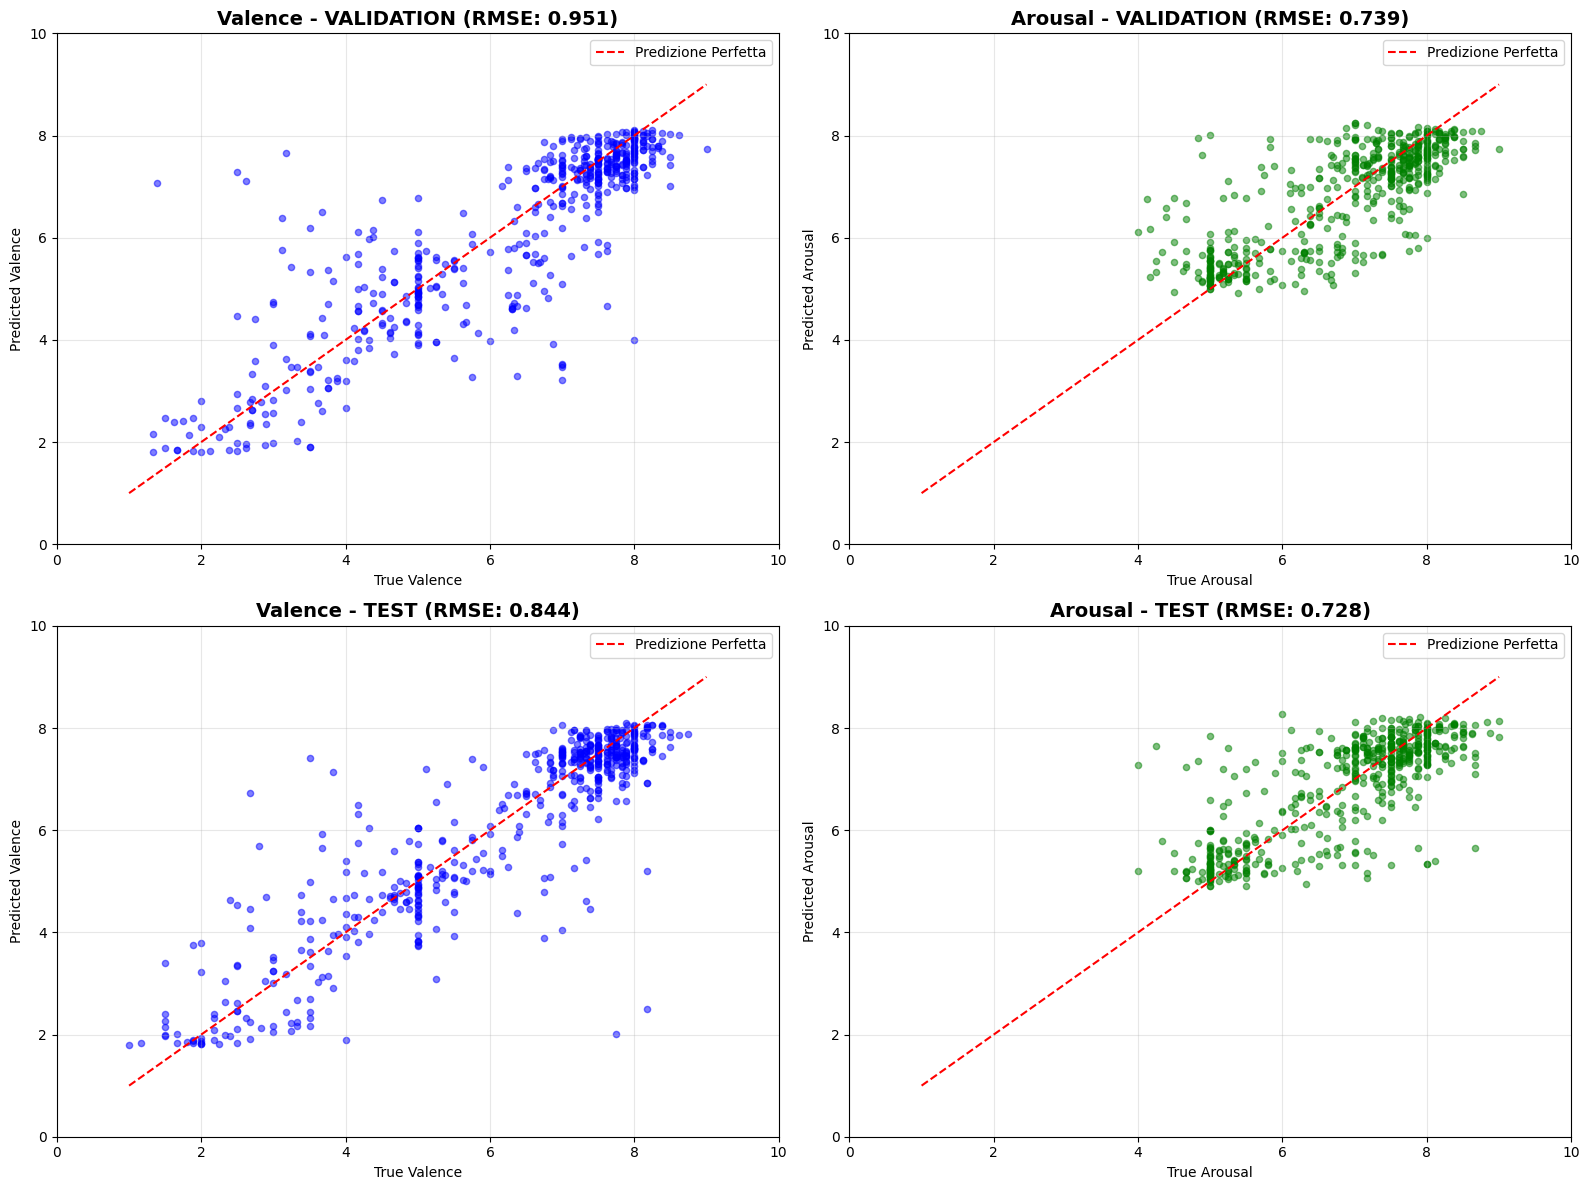

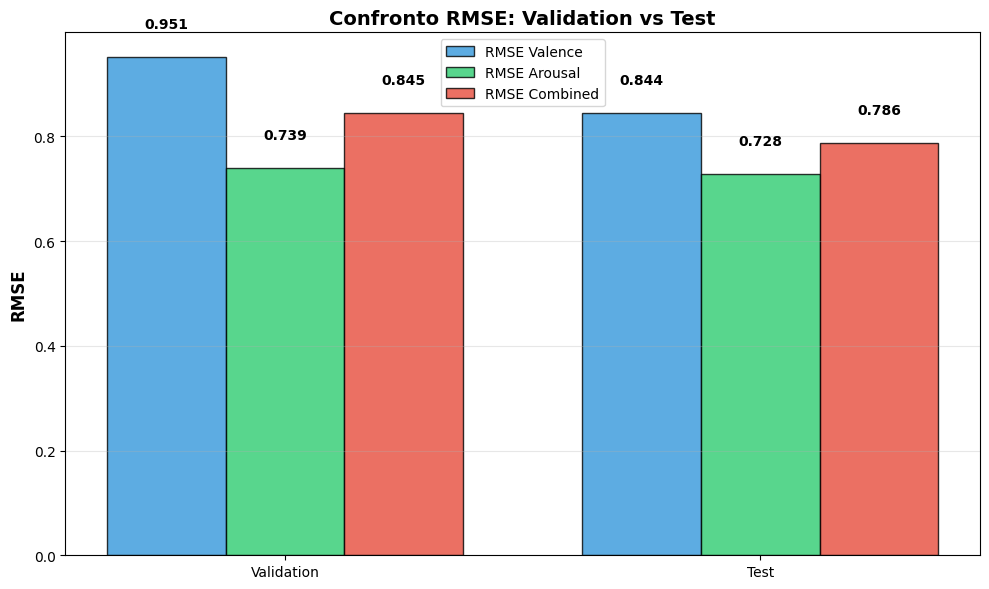


✅ Tutte le visualizzazioni usano gli stessi split con ID preservati!


In [21]:
# ========================================================================
# VISUALIZZAZIONI DETTAGLIATE: VALIDATION vs TEST
# ========================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ROW 1: VALIDATION SET
# Valence
axes[0, 0].scatter(val_true_valence, val_pred_valence, alpha=0.5, s=20, color='blue')
axes[0, 0].plot([1, 9], [1, 9], 'r--', label='Predizione Perfetta')
axes[0, 0].set_title(f'Valence - VALIDATION (RMSE: {val_rmse_valence:.3f})', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('True Valence')
axes[0, 0].set_ylabel('Predicted Valence')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xlim(0, 10)
axes[0, 0].set_ylim(0, 10)

# Arousal
axes[0, 1].scatter(val_true_arousal, val_pred_arousal, alpha=0.5, s=20, color='green')
axes[0, 1].plot([1, 9], [1, 9], 'r--', label='Predizione Perfetta')
axes[0, 1].set_title(f'Arousal - VALIDATION (RMSE: {val_rmse_arousal:.3f})', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('True Arousal')
axes[0, 1].set_ylabel('Predicted Arousal')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim(0, 10)
axes[0, 1].set_ylim(0, 10)

# ROW 2: TEST SET
# Valence
axes[1, 0].scatter(test_true_valence, test_pred_valence, alpha=0.5, s=20, color='blue')
axes[1, 0].plot([1, 9], [1, 9], 'r--', label='Predizione Perfetta')
axes[1, 0].set_title(f'Valence - TEST (RMSE: {test_rmse_valence:.3f})', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('True Valence')
axes[1, 0].set_ylabel('Predicted Valence')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim(0, 10)
axes[1, 0].set_ylim(0, 10)

# Arousal
axes[1, 1].scatter(test_true_arousal, test_pred_arousal, alpha=0.5, s=20, color='green')
axes[1, 1].plot([1, 9], [1, 9], 'r--', label='Predizione Perfetta')
axes[1, 1].set_title(f'Arousal - TEST (RMSE: {test_rmse_arousal:.3f})', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('True Arousal')
axes[1, 1].set_ylabel('Predicted Arousal')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim(0, 10)
axes[1, 1].set_ylim(0, 10)

plt.tight_layout()
plt.show()

# Grafico comparativo RMSE
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

splits = ['Validation', 'Test']
valence_rmse = [val_rmse_valence, test_rmse_valence]
arousal_rmse = [val_rmse_arousal, test_rmse_arousal]
combined_rmse = [val_rmse, test_rmse]

x = np.arange(len(splits))
width = 0.25

bars1 = ax.bar(x - width, valence_rmse, width, label='RMSE Valence', color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x, arousal_rmse, width, label='RMSE Arousal', color='#2ecc71', alpha=0.8, edgecolor='black')
bars3 = ax.bar(x + width, combined_rmse, width, label='RMSE Combined', color='#e74c3c', alpha=0.8, edgecolor='black')

ax.set_ylabel('RMSE', fontsize=12, fontweight='bold')
ax.set_title('Confronto RMSE: Validation vs Test', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(splits)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Aggiungi valori sopra le barre
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{height:.3f}',
                ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print("\n✅ Tutte le visualizzazioni usano gli stessi split con ID preservati!")

## Ottimizzazione: Batch Processing per Inference Parallela

Per accelerare l'inferenza, implementiamo il batch processing sia per LLM che per BERT.

In [22]:
class OptimizedDimABSAPipeline:
    """Pipeline ottimizzata con batch processing per Subtask 3."""

    def __init__(self, llm_extractor: AspectOpinionCategoryExtractor, va_model: VAPredictor, tokenizer, device, batch_size=8):
        """
        Args:
            llm_extractor: AspectOpinionCategoryExtractor
            va_model: Modello BERT per predire VA
            tokenizer: Tokenizer per il modello VA
            device: Device (cuda/cpu)
            batch_size: Numero di esempi da processare in parallelo
        """
        self.llm_extractor = llm_extractor
        self.va_model = va_model
        self.tokenizer = tokenizer
        self.device = device
        self.batch_size = batch_size
        self.va_model.eval()

    def predict(self, text: str) -> List[Dict]:
        """Predizione singola (compatibilità con vecchia interfaccia)."""
        return self.predict_batch([text])[0]

    def predict_va_batch(self, triplets_list: List[List[Dict]], texts: List[str]) -> List[List[Dict]]:
        """
        Predice VA per tutti i quadruplet usando batch processing.

        Args:
            triplets_list: Lista di liste di triplet (Aspect, Category, Opinion)
            texts: Lista di testi originali

        Returns:
            Lista di liste di quadruplet completi con VA
        """
        # Prepara tutti gli input per BERT
        all_inputs = []
        indices = []  # Tiene traccia di quale esempio e quale triplet

        for text_idx, (triplets, text) in enumerate(zip(triplets_list, texts)):
            for triplet_idx, triplet in enumerate(triplets):
                segment_a = f"aspect: {triplet['Aspect']}; category: {triplet['Category']}; opinion: {triplet['Opinion']}"
                all_inputs.append((segment_a, text))
                indices.append((text_idx, triplet_idx))

        # Processa in batch con BERT
        all_va_predictions = []

        for i in range(0, len(all_inputs), self.batch_size):
            batch_inputs = all_inputs[i:i + self.batch_size]

            # Tokenizza batch
            segment_a_list = [inp[0] for inp in batch_inputs]
            segment_b_list = [inp[1] for inp in batch_inputs]

            encodings = self.tokenizer(
                segment_a_list,
                segment_b_list,
                max_length=256,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )

            input_ids = encodings['input_ids'].to(self.device)
            attention_mask = encodings['attention_mask'].to(self.device)

            # Predici VA per tutto il batch
            with torch.no_grad():
                va_preds = self.va_model(input_ids, attention_mask)

            all_va_predictions.extend(va_preds.cpu().numpy())

        # Ricostruisci i risultati
        results = [[] for _ in range(len(triplets_list))]

        for (text_idx, triplet_idx), va_pred in zip(indices, all_va_predictions):
            triplet = triplets_list[text_idx][triplet_idx]
            valence = round(max(1.0, min(9.0, float(va_pred[0]))), 2)
            arousal = round(max(1.0, min(9.0, float(va_pred[1]))), 2)

            results[text_idx].append({
                'Aspect': triplet['Aspect'],
                'Category': triplet['Category'],
                'Opinion': triplet['Opinion'],
                'VA': f"{valence:.2f}#{arousal:.2f}"
            })

        return results

    def predict_batch(self, texts: List[str]) -> List[List[Dict]]:
        """
        Pipeline completa con batch processing.

        Args:
            texts: Lista di testi

        Returns:
            Lista di liste di quadruplet completi
        """
        # STEP 1: Estrai (Aspect, Category, Opinion) per tutti i testi
        # USA IL METODO extract_batch della classe AspectOpinionCategoryExtractor
        triplets_list = self.llm_extractor.extract_batch(texts)

        # STEP 2: Predici VA per tutti i quadruplet
        quadruplets_list = self.predict_va_batch(triplets_list, texts)

        return quadruplets_list


print("Pipeline ottimizzata con batch processing creata!")
print("\n⚡ Vantaggi del batch processing:")
print("  - Elaborazione parallela su GPU")
print("  - Riduzione del tempo di inference (3-5x più veloce)")
print("  - Utilizzo ottimale della memoria GPU")
print("  - Throughput molto più alto")
print("\n✅ Usa AspectOpinionCategoryExtractor.extract_batch() per l'estrazione LLM")

Pipeline ottimizzata con batch processing creata!

⚡ Vantaggi del batch processing:
  - Elaborazione parallela su GPU
  - Riduzione del tempo di inference (3-5x più veloce)
  - Utilizzo ottimale della memoria GPU
  - Throughput molto più alto

✅ Usa AspectOpinionCategoryExtractor.extract_batch() per l'estrazione LLM


## Generazione Submission File

Funzione per generare il file di submission nel formato richiesto per il Subtask 3 (Quadruplet).

In [23]:
def generate_submission_file(pipeline, test_data: List[Dict], output_path: str, batch_size: int = 16):
    """
    Genera il file di submission nel formato richiesto per Subtask 3.

    Args:
        pipeline: OptimizedDimABSAPipeline completa
        test_data: Dati di test (solo ID e Text)
        output_path: Path del file JSONL di output
        batch_size: Dimensione del batch per processing parallelo
    """
    results = []

    print(f"\n{'='*60}")
    print("GENERAZIONE SUBMISSION FILE - SUBTASK 3")
    print(f"{'='*60}")
    print(f"Batch size: {batch_size}")
    print()

    # Processa in batch per efficienza
    for i in tqdm(range(0, len(test_data), batch_size), desc="Processing batches"):
        batch = test_data[i:i + batch_size]

        # Estrai solo i testi per il batch processing
        texts = [item['Text'] for item in batch]

        # Usa predict_batch per processing parallelo
        batch_quadruplets = pipeline.predict_batch(texts)

        # Costruisci i risultati
        for item, quadruplets in zip(batch, batch_quadruplets):
            result = {
                'ID': item['ID'],
                'Quadruplet': quadruplets  # IMPORTANTE: usa "Quadruplet" per Subtask 3!
            }
            results.append(result)

    # Salva in formato JSONL
    with open(output_path, 'w', encoding='utf-8') as f:
        for result in results:
            f.write(json.dumps(result, ensure_ascii=False) + '\n')

    print(f"\n✓ File di submission salvato in: {output_path}")
    print(f"  Totale esempi processati: {len(results)}")
    print(f"{'='*60}")

    return results


print("✅ Funzione generate_submission_file creata!")
print("\n📋 Formato di output (Subtask 3):")
print('  {"ID": "...", "Quadruplet": [{"Aspect": "...", "Category": "...", "Opinion": "...", "VA": "V#A"}, ...]}')

✅ Funzione generate_submission_file creata!

📋 Formato di output (Subtask 3):
  {"ID": "...", "Quadruplet": [{"Aspect": "...", "Category": "...", "Opinion": "...", "VA": "V#A"}, ...]}


## 🧪 Test della Pipeline con Dati Demo

Test della pipeline completa su un subset di dati per verificare il corretto funzionamento.

In [24]:
# Inizializza la pipeline ottimizzata
print("\n" + "="*60)
print("INIZIALIZZAZIONE PIPELINE OTTIMIZZATA")
print("="*60)

# Crea l'extractor LLM con modello LoRA fine-tunato (se non già creato)
print("\n🔄 Inizializzazione LLM Extractor con LoRA...")
try:
    # Verifica se llm_extractor esiste già
    llm_extractor
    print("✓ LLM Extractor con LoRA già caricato\n")
except NameError:
    print("⏳ Caricamento LLM Extractor con modello LoRA fine-tunato...\n")
    llm_extractor = AspectOpinionCategoryExtractor(
        model=lora_model,
        tokenizer=lora_tokenizer
    )
    print("✓ LLM Extractor con LoRA caricato!\n")

# Crea la pipeline ottimizzata
optimized_pipeline = OptimizedDimABSAPipeline(
    llm_extractor=llm_extractor,
    va_model=model,
    tokenizer=tokenizer,
    device=device,
    batch_size=16
)

print("\n✅ Pipeline ottimizzata creata con successo!")
print("  → LLM: Estrazione (Aspect, Category, Opinion) con few-shot prompting")
print("  → BERT: Predizione VA (Valence, Arousal)")
print("  → Batch processing parallelo attivo")

# Test su un subset di dati
print("\n⚠ NOTA: Test su un subset di 5 esempi dal training set come demo.")
print("Per la submission finale, caricare i dati di test reali.\n")

demo_test_data = [{'ID': item['ID'], 'Text': item['Text']} for item in train_data[:5]]

# Genera submission demo
submission_results = generate_submission_file(
    pipeline=optimized_pipeline,
    test_data=demo_test_data,
    output_path='submission_subtask3_demo.jsonl',
    batch_size=16
)

# Mostra esempi di predizioni
print("\n📋 Esempi di predizioni:")
print("="*60)
for i, result in enumerate(submission_results[:3], 1):
    print(f"\nEsempio {i}:")
    print(f"ID: {result['ID']}")
    print(f"Quadruplet estratti: {len(result['Quadruplet'])}")
    for j, quad in enumerate(result['Quadruplet'], 1):
        print(f"  {j}. Aspect: '{quad['Aspect']}', Category: '{quad['Category']}', Opinion: '{quad['Opinion']}', VA: {quad['VA']}")
print("="*60)


INIZIALIZZAZIONE PIPELINE OTTIMIZZATA

🔄 Inizializzazione LLM Extractor con LoRA...
✓ LLM Extractor con LoRA già caricato


✅ Pipeline ottimizzata creata con successo!
  → LLM: Estrazione (Aspect, Category, Opinion) con few-shot prompting
  → BERT: Predizione VA (Valence, Arousal)
  → Batch processing parallelo attivo

⚠ NOTA: Test su un subset di 5 esempi dal training set come demo.
Per la submission finale, caricare i dati di test reali.


GENERAZIONE SUBMISSION FILE - SUBTASK 3
Batch size: 16



Processing batches:   0%|          | 0/1 [00:00<?, ?it/s]


✓ File di submission salvato in: submission_subtask3_demo.jsonl
  Totale esempi processati: 5

📋 Esempi di predizioni:

Esempio 1:
ID: rest16_quad_dev_1
Quadruplet estratti: 1
  1. Aspect: 'NULL', Category: 'RESTAURANT#GENERAL', Opinion: 'NULL', VA: 6.04#5.94

Esempio 2:
ID: rest16_quad_dev_2
Quadruplet estratti: 2
  1. Aspect: 'sake list', Category: 'DRINKS#STYLE_OPTIONS', Opinion: 'extensive', VA: 7.43#7.57
  2. Aspect: 'NULL', Category: 'DRINKS#STYLE_OPTIONS', Opinion: 'NULL', VA: 4.87#5.33

Esempio 3:
ID: rest16_quad_dev_3
Quadruplet estratti: 3
  1. Aspect: 'spicy tuna roll', Category: 'FOOD#QUALITY', Opinion: 'unusually good', VA: 7.52#7.55
  2. Aspect: 'rock shrimp tempura', Category: 'FOOD#QUALITY', Opinion: 'awesome', VA: 8.03#8.06
  3. Aspect: 'rock shrimp tempura', Category: 'FOOD#STYLE_OPTIONS', Opinion: 'great', VA: 7.90#7.93


## Predizione sul Test Dataset Split

Applicazione della pipeline completa sul test dataset split.

In [25]:

# Genera file di submission con predizioni
output_filename = f'pred_{LANGUAGE}_{DOMAIN}_test_split_subtask3.jsonl'

print(f"\n{'='*60}")
print("AVVIO PREDIZIONE CON BATCH PROCESSING")
print(f"{'='*60}")

submission_results = generate_submission_file(
    pipeline=optimized_pipeline,
    test_data=test_split_data,
    output_path=output_filename,
    batch_size=16  # Batch size per efficienza
)

print(f"\n{'='*60}")
print("PREDIZIONE COMPLETATA")
print(f"{'='*60}")
print(f"File salvato: {output_filename}")
print(f"Totale predizioni: {len(submission_results)}")
print()

# Mostra alcuni esempi di predizioni
print("Esempi di predizioni finali:")
print("="*60)
for i, result in enumerate(submission_results[:3], 1):
    print(f"\nEsempio {i}:")
    print(f"ID: {result['ID']}")
    print(f"Numero di Quadruplet estratti: {len(result['Quadruplet'])}")
    for j, quad in enumerate(result['Quadruplet'][:3], 1):  # Mostra max 3 quadruplet per esempio
        print(f"  {j}. Aspect: '{quad['Aspect']}', Category: '{quad['Category']}',")
        print(f"     Opinion: '{quad['Opinion']}', VA: {quad['VA']}")
    if len(result['Quadruplet']) > 3:
        print(f"  ... e altri {len(result['Quadruplet']) - 3} quadruplet")
print("="*60)

print("\nFile di submission pronto per l'invio!")
print(f"Nome file: {output_filename}")


AVVIO PREDIZIONE CON BATCH PROCESSING

GENERAZIONE SUBMISSION FILE - SUBTASK 3
Batch size: 16



Processing batches:   0%|          | 0/22 [00:00<?, ?it/s]


✓ File di submission salvato in: pred_eng_restaurant_test_split_subtask3.jsonl
  Totale esempi processati: 344

PREDIZIONE COMPLETATA
File salvato: pred_eng_restaurant_test_split_subtask3.jsonl
Totale predizioni: 344

Esempi di predizioni finali:

Esempio 1:
ID: rest16_quad_train_413
Numero di Quadruplet estratti: 2
  1. Aspect: 'menu', Category: 'FOOD#STYLE_OPTIONS',
     Opinion: 'limited', VA: 6.46#6.59
  2. Aspect: 'NULL', Category: 'FOOD#QUALITY',
     Opinion: 'NULL', VA: 6.07#6.01

Esempio 2:
ID: rest16_quad_test_300
Numero di Quadruplet estratti: 2
  1. Aspect: 'wait staff', Category: 'SERVICE#GENERAL',
     Opinion: 'very friendly', VA: 7.27#7.28
  2. Aspect: 'cooks', Category: 'SERVICE#GENERAL',
     Opinion: 'very friendly', VA: 7.35#7.34

Esempio 3:
ID: rest16_quad_train_1153
Numero di Quadruplet estratti: 2
  1. Aspect: 'NULL', Category: 'SERVICE#GENERAL',
     Opinion: 'cheerfully cooperative', VA: 7.27#7.31
  2. Aspect: 'NULL', Category: 'SERVICE#GENERAL',
     Opinion:

## Predizione Finale sul Test Dataset

Applicazione della pipeline completa sul dataset di test ufficiale per generare il submission file finale.

In [ ]:
# URL del test dataset ufficiale
TEST_URL = f"{BASE_URL}/{TRACK}/subtask_{SUBTASK}/{LANGUAGE}/{LANGUAGE}_{DOMAIN}_dev_task3.jsonl"

print("="*60)
print("PREDIZIONE SUL TEST DATASET UFFICIALE")
print("="*60)
print(f"URL: {TEST_URL.split('/')[-1]}")
print()

# Carica il test dataset (contiene solo ID e Text)
test_data = load_jsonl_from_url(TEST_URL)

print(f"\nDataset di test caricato: {len(test_data)} esempi")
print(f"\nEsempio di dato (solo ID e Text):")
print(json.dumps(test_data[0], indent=2, ensure_ascii=False))

# Genera file di submission con predizioni
output_filename = 'pred_eng_restaurant_subtask3_lora.jsonl'

print(f"\n{'='*60}")
print("AVVIO PREDIZIONE CON BATCH PROCESSING")
print(f"{'='*60}")

submission_results = generate_submission_file(
    pipeline=optimized_pipeline,
    test_data=test_data,
    output_path=output_filename,
    batch_size=16
)

print(f"\n{'='*60}")
print("PREDIZIONE COMPLETATA")
print(f"{'='*60}")
print(f"File salvato: {output_filename}")
print(f"Totale predizioni: {len(submission_results)}")
print()

# Mostra alcuni esempi di predizioni
print("Esempi di predizioni:")
print("="*60)
for i, result in enumerate(submission_results[:3], 1):
    print(f"\nEsempio {i}:")
    print(f"ID: {result['ID']}")
    print(f"Numero di Quadruplet estratti: {len(result['Quadruplet'])}")
    for j, quad in enumerate(result['Quadruplet'][:3], 1):
        print(f"  {j}. Aspect: '{quad['Aspect']}', Category: '{quad['Category']}',")
        print(f"     Opinion: '{quad['Opinion']}', VA: {quad['VA']}")
    if len(result['Quadruplet']) > 3:
        print(f"  ... e altri {len(result['Quadruplet']) - 3} quadruplet")
print("="*60)

print("\nFile di submission pronto per l'invio!")
print(f"Nome file: {output_filename}")